# Deploy and monitor a machine learning workflow for Image Classification

## Setting up this notebook

Notes about the instance size and kernel setup: this notebook has been tested on

1. The `Python 3 (Data Science)` kernel
2. The `ml.t3.medium` Sagemaker notebook instance

## Data Staging

We'll use a sample dataset called CIFAR. In order to start working with CIFAR we'll need to:

1. Extract the data from a hosting service
2. Transform it into a usable shape and format
3. Load it into a production system

In other words, we're going to do some simple ETL!

### 1. Extract the data from the hosting service

In the cell below, we define a function `extract_cifar_data` that extracts python version of the CIFAR-100 dataset. The CIFAR dataaset is open source and generously hosted by the University of Toronto at: https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz 

In [1]:
import requests

def extract_cifar_data(url, filename="cifar.tar.gz"):
    """A function for extracting the CIFAR-100 dataset and storing it as a gzipped file
    
    Arguments:
    url      -- the URL where the dataset is hosted
    filename -- the full path where the dataset will be written
    
    """
    
    r = requests.get(url)
    with open(filename, "wb") as file_context:
        file_context.write(r.content)

The following cell saves a new file called `cifar.tar.gz`. This file contains the CIFAR-100 dataset in a gzipped archive.

In [2]:
extract_cifar_data("https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz")     

### 2. Transform the data into a usable shape and format

Clearly, distributing the data as a gzipped archive makes sense for the hosting service! It saves on bandwidth, storage, and it's a widely-used archive format. In fact, it's so widely used that the Python community ships a utility for working with them, `tarfile`, as part of its Standard Library.
We'll use this utility to decompress the archive and extract the files.

In [3]:
import tarfile

with tarfile.open("cifar.tar.gz", "r:gz") as tar:
    tar.extractall()

A new folder `cifar-100-python` is created, containing `meta`, `test`, and `train` files. These files are `pickles` and the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html) provides a simple script that can be used to load them. We've adapted the script below:

In [6]:
import pickle

with open("./cifar-100-python/meta", "rb") as f:
    dataset_meta = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/test", "rb") as f:
    dataset_test = pickle.load(f, encoding='bytes')

with open("./cifar-100-python/train", "rb") as f:
    dataset_train = pickle.load(f, encoding='bytes')

In [5]:
dataset_train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

As documented on the homepage, `b'data'` contains rows of 3073 unsigned integers, representing three channels (red, green, and blue) for one 32x32 pixel image per row.

For a simple gut-check, let's transform one of our images. Each 1024 items in a row is a channel (red, green, then blue). Each 32 items in the channel are a row in the 32x32 image. Using python, we can stack these channels into a 32x32x3 array, and save it as a PNG file:

In [8]:
import numpy as np

# Each 1024 in a row is a channel (red, green, then blue)
row = dataset_train[b'data'][0]
side_length = 32
channel_length = side_length ** 2
test_image = np.dstack((
    row[0:channel_length].reshape(side_length, side_length),  # Red
    row[channel_length:channel_length*2].reshape(side_length, side_length),  # Green
    row[channel_length*2:].reshape(side_length, side_length)  # Blue
))

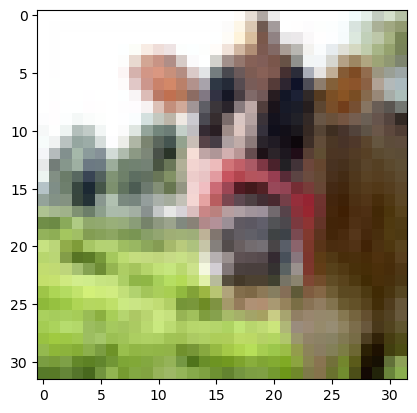

In [9]:
import matplotlib.pyplot as plt
plt.imshow(test_image);

Looks like a cow! Let's check the label. `dataset_meta` contains label names in order, and `dataset_train` has a list of labels for each row.

In [10]:
dataset_train[b'fine_labels'][0]

19

Our image has a label of `19`, so let's see what the 19th item is in the list of label names.

In [11]:
print(dataset_meta[b'fine_label_names'][19])

b'cattle'


Ok! 'cattle' sounds about right. By the way, using the previous two lines we can do:

In [12]:
n = 0
print(dataset_meta[b'fine_label_names'][dataset_train[b'fine_labels'][n]])

b'cattle'


Now we know how to check labels, is there a way that we can also check file names? `dataset_train` also contains a `b'filenames'` key. Let's see what we have here:

In [13]:
print(dataset_train[b'filenames'][0])

b'bos_taurus_s_000507.png'


"Taurus" is the name of a subspecies of cattle, so this looks like a pretty reasonable filename. To save an image we can also do:

In [14]:
plt.imsave("file.png", test_image)


Now that we know how to reshape the images, save them as files, and capture their filenames and labels, let's just capture all the bicycles and motorcycles and save them.

In the following cell, we identify the label numbers for Bicycles and Motorcycles:

In [7]:
import pandas as pd

df_train = pd.DataFrame({
    "filenames": dataset_train[b'filenames'],
    "labels": dataset_train[b'fine_labels'],
    "row": range(len(dataset_train[b'filenames']))
})

dataset_meta = pd.DataFrame({
    "fine_label_names": dataset_meta[b'fine_label_names'],
    "fine_labels": range(len(dataset_meta[b'fine_label_names']))
})

# identify the label numbers for Bicycles and Motorcycles:
interesting_labels = dataset_meta[dataset_meta["fine_label_names"].isin([b'bicycle', b'motorcycle'])]["fine_labels"]
interesting_labels

8      8
48    48
Name: fine_labels, dtype: int64

We only need objects with label 8 and 48 -- this drastically simplifies our handling of the data! Below we construct a dataframe, droping the rows that don't contain observations about bicycles and motorcycles.

In [ ]:

# Drop all rows from df_train where label is not 8 or 48
df_train = df_train[df_train["labels"].isin(interesting_labels)]

# Decode df_train.filenames, so they are regular strings
df_train["filenames"] = df_train["filenames"].apply(
    lambda x: x.decode("utf-8")
)


df_test = pd.DataFrame({
    "filenames": dataset_test[b'filenames'],
    "labels": dataset_test[b'fine_labels'],
    "row": range(len(dataset_test[b'filenames']))
})

# Drop all rows from df_test where label is not 8 or 48
df_test = df_test[df_test["labels"].isin(interesting_labels)]

# Decode df_test.filenames, so they are regular strings
df_test["filenames"] = df_test["filenames"].apply(
    lambda x: x.decode("utf-8")
)


Now that the data is filtered for just our classes, we can save all our images.

In [19]:
!mkdir ./train
!mkdir ./test

In [37]:
def save_images(df, path):
    os.makedirs(path, exist_ok=True)
    dataset = dataset_train if "train" in path else dataset_test
    for _, row in df.iterrows():
        # Reshape and stack the image data into the correct shape
        img = dataset[b'data'][row['row']]

        side_length = 32
        channel_length = side_length ** 2
        image = np.dstack((
            img[0:channel_length].reshape(side_length, side_length),  # Red
            img[channel_length:channel_length*2].reshape(side_length, side_length),  # Green
            img[channel_length*2:].reshape(side_length, side_length)  # Blue
        ))
        # Generate the full path for the image file
        full_path = os.path.join(path, row['filenames'])
        # Save the image
        plt.imsave(full_path, image)

# save ALL images using the save_images function
save_images(df_train, "./train/")
save_images(df_test, "./test/")

### 3. Load the data

Now we can load the data into S3.

Using the sagemaker SDK, we grab the current region, execution role, and bucket.

In [2]:
import sagemaker

session = sagemaker.Session()
bucket = session.default_bucket()
print("Default Bucket: {}".format(bucket))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Default Bucket: sagemaker-us-east-1-087802114688
AWS Region: us-east-1
RoleArn: arn:aws:iam::087802114688:role/service-role/AmazonSageMaker-ExecutionRole-20240801T223647


With this data we can easily sync the data up into S3!

In [39]:
import os

os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./train s3://${DEFAULT_S3_BUCKET}/train/
!aws s3 sync ./test s3://${DEFAULT_S3_BUCKET}/test/

upload: train/bicycle_s_000017.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000017.png
upload: train/bicycle_s_000043.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000043.png
upload: train/bicycle_s_000039.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000039.png
upload: train/bicycle_s_000066.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000066.png
upload: train/bicycle_s_000038.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000038.png
upload: train/bicycle_s_000035.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000035.png
upload: train/bicycle_s_000021.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000021.png
upload: train/bicycle_s_000051.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000051.png
upload: train/bicycle_s_000156.png to s3://sagemaker-us-east-1-087802114688/train/bicycle_s_000156.png
upload: train/bicycle_s_000149.png to s3://sagemaker-us-east-1-0878021146

And that's it! the items were uploaded.

## Model Training

For Image Classification, Sagemaker [also expects metadata](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html) e.g. in the form of TSV files with labels and filepaths. We can generate these using our Pandas DataFrames from earlier:

In [40]:
def to_metadata_file(df, prefix):
    df["s3_path"] = df["filenames"]
    df["labels"] = df["labels"].apply(lambda x: 0 if x==8 else 1)
    return df[["row", "labels", "s3_path"]].to_csv(
        f"{prefix}.lst", sep="\t", index=False, header=False
    )
    
to_metadata_file(df_train.copy(), "train")
to_metadata_file(df_test.copy(), "test")

We can also upload our manifest files:

In [41]:
import boto3

# Upload files
bucket_object = boto3.Session().resource('s3').Bucket(bucket)
bucket_object.Object('train.lst').upload_file('./train.lst')
bucket_object.Object('test.lst').upload_file('./test.lst')

Using the `bucket` and `region` info we can get the latest prebuilt container to run our training job, and define an output location on our s3 bucket for the model.

In [42]:
# We use the `image_uris` function from the SageMaker SDK to retrieve the latest `image-classification` image:
from sagemaker import image_uris
algo_image = image_uris.retrieve(
    region=region,
    framework="image-classification",
    version="latest"
)
    
s3_output_location = f"s3://{bucket}/models/image_model"

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [43]:
img_classifier_model=sagemaker.estimator.Estimator(
    image_uri=algo_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    output_path=s3_output_location,
    sagemaker_session=sagemaker.Session()
)

We can also set a few key hyperparameters and define the inputs for our model:

In [47]:
img_classifier_model.set_hyperparameters(
    image_shape="3,32,32",
    num_classes=df_train["labels"].nunique(),
    num_training_samples=len(df_train),
)

In [48]:
# from sagemaker.debugger import Rule, rule_configs
# from sagemaker.session import TrainingInput
model_inputs = {
        "train": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train/",
            content_type="application/x-image"
        ),
        "validation": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test/",
            content_type="application/x-image"
        ),
        "train_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/train.lst",
            content_type="application/x-image"
        ),
        "validation_lst": sagemaker.inputs.TrainingInput(
            s3_data=f"s3://{bucket}/test.lst",
            content_type="application/x-image"
        )
}

Great, now we can train the model using the model_inputs:

In [49]:
img_classifier_model.fit(inputs=model_inputs)

INFO:sagemaker:Creating training-job with name: image-classification-2024-08-01-20-46-59-049


2024-08-01 20:46:59 Starting - Starting the training job...
2024-08-01 20:46:59 Pending - Training job waiting for capacity...................................................
2024-08-01 20:55:50 Pending - Preparing the instances for training...
2024-08-01 20:56:30 Downloading - Downloading input data...
2024-08-01 20:56:50 Downloading - Downloading the training image.................................
2024-08-01 21:02:14 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Aug  1 21:02:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name       

We got a model topping out above `.8` validation accuracy. With only 1000 training samples in the CIFAR dataset, that's pretty good. We could definitely pursue data augmentation & gathering more samples to help us improve further, but for now let's proceed to deploy our model, as this is the main focus of this project.

### Getting ready to deploy

To begin with, let's configure Model Monitor to track our deployment. We'll define a `DataCaptureConfig` below:

In [50]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=f"s3://{bucket}/data_capture"
)

Note the `destination_s3_uri` parameter: At the end of the project, we can explore the `data_capture` directory in S3 to find crucial data about the inputs and outputs Model Monitor has observed on our model endpoint over time.

With that done, we deploy the model on a single `ml.m5.xlarge` instance with the data capture config attached:

In [51]:
deployment = img_classifier_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge',
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

INFO:sagemaker:Creating model with name: image-classification-2024-08-01-21-08-40-899
INFO:sagemaker:Creating endpoint-config with name image-classification-2024-08-01-21-08-40-899
INFO:sagemaker:Creating endpoint with name image-classification-2024-08-01-21-08-40-899


---------------!image-classification-2024-08-01-21-08-40-899


Note the endpoint name for later as well.

Next, instantiate a Predictor:

In [65]:
predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint, sagemaker_session=sagemaker.Session())

In the code snippet below we are going to prepare one of the saved images for prediction.

In [53]:
from sagemaker.serializers import IdentitySerializer
# import base64

predictor.serializer = IdentitySerializer("image/png")
with open("./test/bicycle_s_001789.png", "rb") as f:
    payload = f.read()

    
inference = predictor.predict(payload)

The `inference` object is an array of two values, the predicted probability value for each of the classes (bicycle and motorcycle respectively.) So, for example, a value of `b'[0.91, 0.09]'` indicates the probability of being a bike is 91% and being a motorcycle is 9%.

In [54]:
print(inference)

b'[0.9881280064582825, 0.011871996335685253]'


In [70]:
from sagemaker.model_monitor import DefaultModelMonitor
from sagemaker.model_monitor import CronExpressionGenerator
# from sagemaker.model_monitor.dataset_format import DatasetFormat

# Define the model monitor
model_monitor = DefaultModelMonitor(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    volume_size_in_gb=10,
    max_runtime_in_seconds=3600,
)

# Define the schedule
model_monitor.create_monitoring_schedule(
    endpoint_input=endpoint,
    output_s3_uri=f"s3://{bucket}/model_monitoring",
    schedule_cron_expression=CronExpressionGenerator.hourly(),
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: .
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.model_monitor.model_monitoring:Creating Monitoring Schedule with name: monitoring-schedule-2024-08-02-06-46-19-904


### Lambdas and Step Function Workflow

Assuming the operations team uses Step Functions to orchestrate serverless workflows. One of the nice things about Step Functions is that [workflows can call other workflows](https://docs.aws.amazon.com/step-functions/latest/dg/connect-stepfunctions.html), so the team can easily plug the workflow into the broader production architecture for Scones Unlimited.

Now we define and deploy three Lambda functions in the cloud, and then use the Step Functions visual editor to chain them together! Our functions are going to work with a simple data object:

```python
{
    "inferences": [], # Output of predictor.predict
    "s3_key": "", # Source data S3 key
    "s3_bucket": "", # Source data S3 bucket
    "image_data": ""  # base64 encoded string containing the image data
}
```

Using these fields, the functions can read and write the necessary data to execute the workflow. 
- The first Lambda function copy an object from S3, base64 encode it, and then return it to the step function as `image_data` in an event.

- The second function is responsible for the classification part - we're taking the image output from the previous function, decode it, and then pass inferences back to the Step Function.

Because this Lambda have runtime dependencies (i.e. the SageMaker SDK) we package them in the function. *Key reading:* https://docs.aws.amazon.com/lambda/latest/dg/python-package-create.html#python-package-create-with-dependency
(in SageMaker CLI we install the package, plus some specific dependencies that caused error, add the handler, zip everything together and copy to s3)

- Finally, we need to filter low-confidence inferences.

With the lambdas in place, we can use the Step Functions visual editor to construct a workflow that chains them together (a bit costly, but ok).  
Here's how it looks like:

![Step Functions Workflow](step_function/Screenshot_14.png)

(The code defining the workflow is in the `workflow.json` file in the project directory, and the lambdas are in the `lambdas` folder.)

Great! Now we can use the files in `./test` as test files for our workflow. Depending on the threshold, our workflow should reliably pass predictions about images from `./test` on to downstream systems, while erroring out for inferences below our confidence threshold!

### Testing and Evaluation

We do several step function invokations using data from the `./test` folder to gain confidence that the workflow both *succeeds* AND *fails* as expected. In addition, SageMaker Model Monitor will generate recordings of the data and inferences which we can visualize.


In [77]:
import random
import boto3


def generate_test_cases(k):
    # Setup s3 in boto3
    s3 = boto3.resource('s3')
    
    # Randomly pick from sfn or test folders in our bucket
    objects = s3.Bucket(bucket).objects.filter(Prefix="test")
    
    # Grab some random object keys from that folder
    objs = random.choices([x.key for x in objects], k=k)
    
    return [{"s3_bucket": bucket, "s3_key": obj} for obj in objs]

test_cases = generate_test_cases(k=15)

s3 = boto3.client('s3')
predictor.serializer = IdentitySerializer("image/png")
for case in test_cases:
    # get payload from s3
    key = case["s3_key"]
    obj = s3.get_object(Bucket=bucket, Key=key)
    payload = obj.get('Body').read()
    
    print(case["s3_key"], predictor.predict(payload))

test/velocipede_s_001232.png b'[0.9973804354667664, 0.0026195489335805178]'
test/velocipede_s_000106.png b'[0.9967719912528992, 0.0032279922161251307]'
test/minibike_s_001893.png b'[0.054450567811727524, 0.9455494284629822]'
test/bike_s_000163.png b'[0.8525035977363586, 0.14749646186828613]'
test/minibike_s_000947.png b'[0.4839552044868469, 0.5160447359085083]'
test/moped_s_000306.png b'[0.020784100517630577, 0.9792159199714661]'
test/motorcycle_s_000323.png b'[0.7349382042884827, 0.26506176590919495]'
test/moped_s_000033.png b'[0.005973618943244219, 0.9940264225006104]'
test/bicycle_s_001102.png b'[0.9966241121292114, 0.003375904867425561]'
test/motorcycle_s_000485.png b'[0.09675966948270798, 0.9032403230667114]'
test/bicycle_s_000479.png b'[0.3496590554714203, 0.6503409743309021]'
test/motorcycle_s_000139.png b'[0.014106813818216324, 0.9858931303024292]'
test/motorcycle_s_000739.png b'[0.009858625940978527, 0.9901413321495056]'
test/motorcycle_s_000825.png b'[0.11624391376972198, 0.8

In [78]:
from sagemaker.s3 import S3Downloader

# In S3 the data will be saved to a datetime-aware path
#   so we can find a path related to a datetime we're interested in
data_path = "s3://{}/data_capture/".format(bucket)

captured_data = S3Downloader.download(data_path, "captured_data")
print(len(captured_data))
captured_data
# We can repeat this multiple times and pull in more data

15


['captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/01/21/17-28-698-3f3ea892-a4b6-40ce-8c6d-708493da87cb.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/02/16-03-466-cfbc1d9f-4bbb-4558-96bc-0f55604b68ff.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/04/16-31-548-dfdd2e31-3134-435e-a3f7-28a9f5bd18d6.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/04/21-28-879-63ae6f6c-651e-4578-9f9d-b95011366ee1.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/04/32-47-804-b1856d11-c743-417c-9bb1-20921e1da698.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/04/47-26-881-13968498-a7c5-40d4-9bdc-f928c7318bf5.jsonl',
 'captured_data/image-classification-2024-08-01-21-08-40-899/AllTraffic/2024/08/02/04/50-24-433-488a36df-c1f9-4243-aa48-1ca31a4a765b.jsonl',
 'captured_da

The data are in JSONLines format, where multiple valid JSON objects are stacked on top of eachother in a single `jsonl` file. We'll import an open-source library, `jsonlines` that was purpose built for parsing this format.

In [10]:
!pip install jsonlines
import jsonlines

Now we can extract the data from each of the source files:

In [3]:
import os

# walk the directory and grab all the files
json_data = []
for root, subdirs, files in os.walk("./captured_data"):
    for file in files:
        file_path = os.path.join(root, file)
        with jsonlines.open(file_path) as reader:
            for obj in reader:
                json_data.append(obj)


The data is now a list of dictionaries, with significant nesting.

In [4]:
import json
from datetime import datetime

# Define how we'll get our data
def simple_getter(obj):
    inferences = obj["captureData"]["endpointOutput"]["data"]
    timestamp = obj["eventMetadata"]["inferenceTime"]
    return json.loads(inferences), datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%SZ')

simple_getter(json_data[0])

([0.9881280064582825, 0.011871996335685253],
 datetime.datetime(2024, 8, 1, 21, 17, 28))

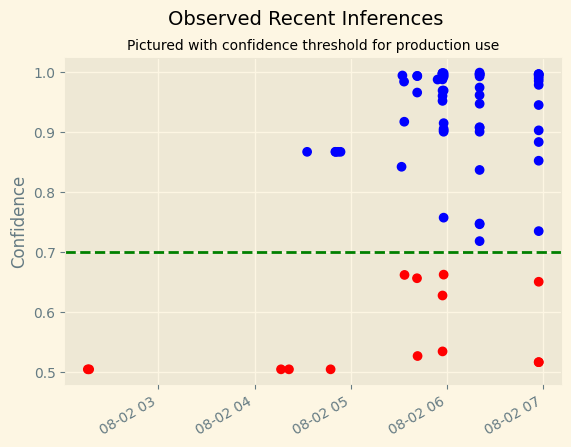

In [7]:
import matplotlib.pyplot as plt
# TODO: if the model is confident it doesn't mean it is right. We should compare the actual labels.

# Populate the data
data = []
for obj in json_data:
    inference, timestamp = simple_getter(obj)
    data.append((timestamp, max(inference)))
data.sort()  # by timestamp

# Plot the data
threshold = 0.7
plt.scatter(*zip(*data), c=['r' if k<threshold else 'b' for ts, k in data])
plt.axhline(y=threshold, color='g', linestyle='--')

# Add labels
plt.ylabel("Confidence")
plt.suptitle("Observed Recent Inferences", size=14)
plt.title("Pictured with confidence threshold for production use", size=10)

# Give it some pizzaz!
plt.style.use("Solarize_Light2")
plt.gcf().autofmt_xdate()

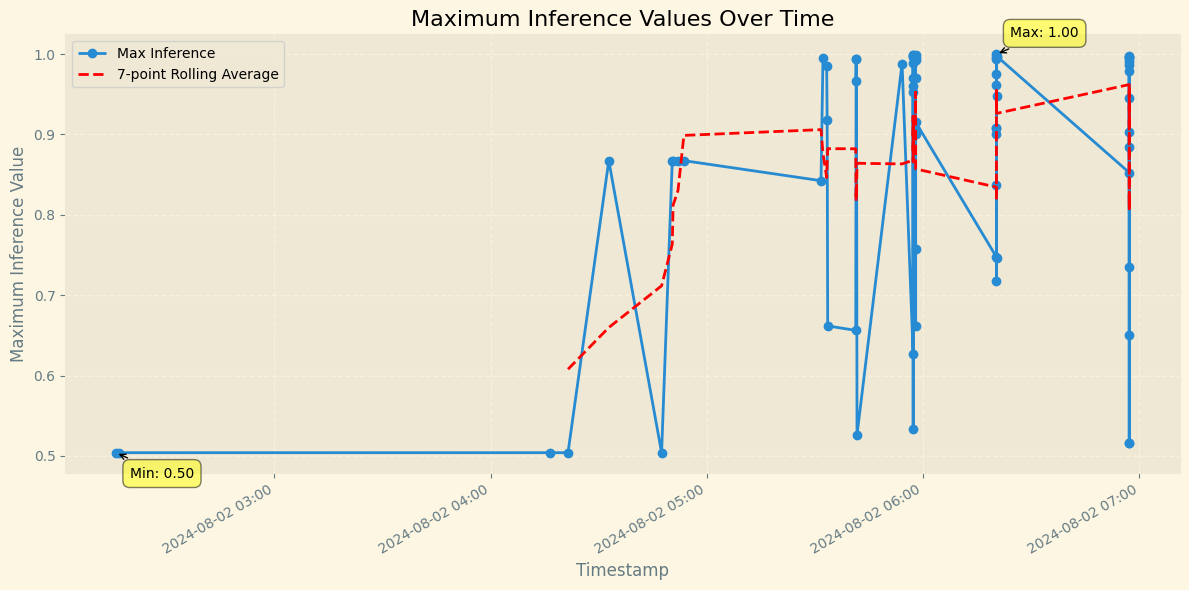

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Unpack the data
timestamps, max_inferences = zip(*data)

# Convert to DataFrame for easier manipulation
df = pd.DataFrame({'timestamp': timestamps, 'max_inference': max_inferences})
df.set_index('timestamp', inplace=True)

# Calculate rolling average
window = max(2, len(df) // 10)  # Use 10% of the data points for the window
rolling_avg = df['max_inference'].rolling(window=window, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['max_inference'], marker='o', linestyle='-', linewidth=2, markersize=6, label='Max Inference')
plt.plot(df.index, rolling_avg, 'r--', linewidth=2, label=f'{window}-point Rolling Average')

plt.title("Maximum Inference Values Over Time", fontsize=16)
plt.xlabel("Timestamp", fontsize=12)
plt.ylabel("Maximum Inference Value", fontsize=12)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gcf().autofmt_xdate()  # Rotate and align the tick labels

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend()

# Highlight the highest and lowest points
max_point = df['max_inference'].max()
min_point = df['max_inference'].min()
max_index = df['max_inference'].idxmax()
min_index = df['max_inference'].idxmin()

plt.annotate(f'Max: {max_point:.2f}', xy=(max_index, max_point), xytext=(10, 10),
             textcoords='offset points', ha='left', va='bottom',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.annotate(f'Min: {min_point:.2f}', xy=(min_index, min_point), xytext=(10, -10),
             textcoords='offset points', ha='left', va='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
             arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

plt.tight_layout()
plt.show()

### Summary

In this project we created an event-drivent ML workflow that can be incorporated into the Scones Unlimited production architecture.
We used the SageMaker Estimator API to deploy an SageMaker Model and Endpoint, and used AWS Lambda and Step Functions to orchestrate the ML workflow.
Using SageMaker Model Monitor, we instrumented and observed the Endpoint, and at the end of the project we built a visualization to help stakeholders understand the performance of the Endpoint over time. 

Future work could include:

* Extend the workflow to incorporate more classes: the CIFAR dataset includes other vehicles.
* Modify the event driven workflow: rewrite the Lambda functions so that the workflow can process multiple image inputs in parallel, and change the step function to reflect this.
* create a "dummy data" generator, to simulate a continuous stream of input data, or a big paralell load of data.
* Use the Step Functions visual editor in conjunction with a service like SNS to notify the operations team when the workflow fails.


